In [471]:
import json
import os
import datetime

with open('/Users/marie/Documents/github/config.json', 'r') as f:
    config = json.load(f)

    for key in config:
        os.environ[key] = config[key]

In [472]:
import requests 
import io
import pandas as pd
import json

In [3]:
# ! ollama pull llama3.1:8b

In [4]:
# ! pip install -qU langchain_ollama

### Setting up Llama

In [5]:
import langchain
langchain.debug = False

In [6]:
from langchain_ollama import OllamaLLM, ChatOllama

llm = OllamaLLM(model="llama3.1:8b")
llm.invoke("How are you?")

"I'm just a language model, I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?"

In [7]:
def get_llama_prompt(user_message, system_message=""):
    system_prompt = ""
    if system_message != "":
        system_prompt = (
            f"<|start_header_id|>system<|end_header_id|>\n\n{system_message}"
            f"<|eot_id|>"
        )
    prompt = (f"<|begin_of_text|>{system_prompt}"
              f"<|start_header_id|>user<|end_header_id|>\n\n"
              f"{user_message}"
              f"<|eot_id|>"
              f"<|start_header_id|>assistant<|end_header_id|>\n\n"
         )
    return prompt   

In [8]:
system_prompt = '''
You are Rudolph, the spirited reindeer with a glowing red nose, bursting with excitement as you prepare to lead Santa's sleigh 
through snowy skies. Your joy shines as brightly as your nose, eager to spread Christmas cheer to the world!
Please, answer questions concisely in 1-2 sentences.
'''
prompt = get_llama_prompt('How are you?', system_prompt)

In [9]:
llm.invoke(prompt)

"I'm buzzing with excitement! My shiny red nose is aglow and I'm feeling simply magnificent, ready to lead Santa's sleigh on this merry Christmas Eve flight!"

### ClickHouse

In [10]:
CH_HOST = 'http://localhost:8123' # default address 
import requests
import io

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
  r = requests.post(host, params = {'query': query}, 
    timeout = connection_timeout)
  if r.status_code == 200:
      return pd.read_csv(io.StringIO(r.text), sep = '\t')
  else: 
      return 'Database returned the following error:\n' + r.text
      # giving feedback to LLM instead of raising exception

In [11]:
get_clickhouse_data('show tables from ecommerce format TabSeparatedWithNames')

,name
0,sessions
1,users


In [12]:
q = '''
select * 
from ecommerce.sessions
limit 5
format TabSeparatedWithNames
'''

get_clickhouse_data(q)

,user_id,session_id,action_date,session_duration,os,browser,is_fraud,revenue
0,1000001,1,2021-01-02,125,Windows,Chrome,0,0.0
1,1000001,2,2021-01-03,496,Windows,Chrome,0,1506.7
2,1000002,23,2021-01-03,651,Windows,Chrome,0,0.0
3,1000005,76,2021-01-04,372,Windows,Chrome,0,1428.5
4,1000007,106,2021-01-04,661,Windows,Chrome,0,6823.7


In [13]:
q = '''
select * 
from ecommerce.users
limit 5
format TabSeparatedWithNames
'''

get_clickhouse_data(q)

,user_id,country,is_active,age
0,1000001,Netherlands,1,47
1,1000002,United Kingdom,1,52
2,1000003,Netherlands,1,41
3,1000004,United Kingdom,1,72
4,1000005,Netherlands,1,63


In [14]:
q = '''
select count(1) 
from ecommerce.users
where is_active = 1
format TabSeparatedWithNames
'''

get_clickhouse_data(q)

,count()
0,592800


### SQL agent - first version

In [15]:
generate_query_system_prompt = '''
You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- session_id (integer) - unique identifier of session, for example, 106 or 1023
- action_date (date) - session start date, for example, "2021-01-03" or "2024-12-02"
- session_duration (integer) - duration of session in seconds, for example, 125 or 49
- os (string) - operation system that customer used, for example, "Windows" or "Android"
- browser (string) - browser that customer used, for example, "Chrome" or "Safari"
- is_fraud (integer) - 1 if session is marked as fraud and 0 otherwise
- revenue (float) - income in USD (the sum of purchased items), for example, 0.0 or 1506.7


Write a query in ClickHouse SQL to answer the following question. 
Add "format TabSeparatedWithNames" at the end of the query to get data from ClickHouse database in the right format. 
Answer questions following the instructions and providing all the needed information and sharing your reasoning. 
'''

In [16]:
prompt = get_llama_prompt('How many customers made purchase in December 2024?', generate_query_system_prompt)

In [17]:
print(llm.invoke(prompt))

To answer this question, we need to find the number of unique users who had a session with a revenue greater than 0 in December 2024.

Here is the query:

```sql
SELECT count(DISTINCT user_id) AS num_customers
FROM ecommerce.sessions
WHERE action_date >= '2024-12-01'
  AND action_date < '2025-01-01'
  AND revenue > 0;
```

When we run this query in ClickHouse, we add the "format TabSeparatedWithNames" at the end to get the data in the correct format:

```sql
SELECT count(DISTINCT user_id) AS num_customers
FROM ecommerce.sessions
WHERE action_date >= '2024-12-01'
  AND action_date < '2025-01-01'
  AND revenue > 0;
format TabSeparatedWithNames;
```

This query will return the number of unique customers who made a purchase in December 2024.


In [18]:
# https://python.langchain.com/docs/integrations/chat/ollama/

In [19]:
from langchain_ollama import OllamaLLM, ChatOllama

In [20]:
from langchain_core.tools import tool

@tool
def execute_query(comments: str, query: str) -> str:
    """Excutes SQL query.

    Args:
        comments (str): 1-2 sentences describing the result SQL query and what it does to answer the question,
        query (str): SQL query
    """
    pass

In [21]:
chat_llm = ChatOllama(model="llama3.1:8b").bind_tools([execute_query])

In [22]:
generate_query_system_prompt = '''
You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- session_id (integer) - unique identifier of session, for example, 106 or 1023
- action_date (date) - session start date, for example, "2021-01-03" or "2024-12-02"
- session_duration (integer) - duration of session in seconds, for example, 125 or 49
- os (string) - operation system that customer used, for example, "Windows" or "Android"
- browser (string) - browser that customer used, for example, "Chrome" or "Safari"
- is_fraud (integer) - 1 if session is marked as fraud and 0 otherwise
- revenue (float) - income in USD (the sum of purchased items), for example, 0.0 or 1506.7


Write a query in ClickHouse SQL to answer the following question. 
Add "format TabSeparatedWithNames" at the end of the query to get data from ClickHouse database in the right format. 
Follow the provided instructions and always use tool to execute query.
'''

In [23]:
prompt = get_llama_prompt('Which country had the highest number of first-time users in 2024?', generate_query_system_prompt)

In [24]:
result = chat_llm.invoke(prompt)

In [25]:
result.tool_calls

[{'name': 'execute_query',
  'args': {'comments': 'Query to find the country with the highest number of first-time users in 2024.',
   'query': 'SELECT T1.country FROM ecommerce.users AS T1 JOIN ecommerce.sessions AS T2 ON T1.user_id = T2.user_id WHERE T1.is_active = 1 AND YEAR(T2.action_date) = 2024 AND T2.session_id NOT IN (SELECT session_id FROM ecommerce.sessions GROUP BY user_id HAVING COUNT(session_id) > 1) GROUP BY T1.country ORDER BY COUNT(*) DESC LIMIT 1'},
  'id': '1c5000ec-78cb-4408-ac3a-dedcd6bf9457',
  'type': 'tool_call'}]

In [26]:
result.tool_calls[0]['args']['query']

'SELECT T1.country FROM ecommerce.users AS T1 JOIN ecommerce.sessions AS T2 ON T1.user_id = T2.user_id WHERE T1.is_active = 1 AND YEAR(T2.action_date) = 2024 AND T2.session_id NOT IN (SELECT session_id FROM ecommerce.sessions GROUP BY user_id HAVING COUNT(session_id) > 1) GROUP BY T1.country ORDER BY COUNT(*) DESC LIMIT 1'

### Evaluating quality

In [49]:
golden_set = [
    {
        "question": "How many customers made purchase in December 2024?",
        "sql_query": "select uniqExact(user_id) as customers from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) format TabSeparatedWithNames" 
    },
    {
        "question": "What was the fraud rate in 2023, expressed as a percentage?",
        "sql_query": "select 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') format TabSeparatedWithNames"
    },
    {
        "question": "What was the share of users using Windows yesterday?",
        "sql_query": "select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames"
    },
    {
        "question": "What was the revenue from Dutch users aged 55 and older in December 2024",
        "sql_query": "select sum(s.revenue) from ecommerce.sessions AS s inner join ecommerce.users AS u on s.user_id = u.user_id where (u.country = 'Netherlands') AND (u.age >= 55) and (toStartOfMonth(action_date) = '2024-12-01') format TabSeparatedWithNames"
    },
    {
        "question": "What are the median and interquartile range (IQR) of purchase revenue for each country?",
        "sql_query": "select country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) group by country format TabSeparatedWithNames"
    },
    {
        "question": "What is the average number of days between the first session and the first purchase for users who made at least one purchase?", 
        "sql_query": "select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select user_id, min(action_date) as first_action_date, minIf(action_date, revenue > 0) as first_purchase, max(revenue) as max_revenue from ecommerce.sessions group by user_id) where max_revenue > 0 format TabSeparatedWithNames"
    },
    {
        "question": "What is the number of sessions in December 2024, broken down by operating systems, including the totals?",
        "sql_query": "SELECT os, uniqExact(session_id) as total FROM ecommerce.sessions WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY os with totals format TabSeparatedWithNames"
    },
    {
        "question": "Do we have customers who used multiple operating browsers during 2024? If so, please calculate the number of customers for each combination of browsers.",
        "sql_query": "select browsers, count(1) as users from (select user_id, arrayStringConcat(arraySort(groupArray(distinct browser)), ', ') as browsers from ecommerce.sessions where (toStartOfYear(action_date) = '2024-01-01') group by user_id) group by browsers order by users desc format TabSeparatedWithNames"
    },
    {
        "question": "Which browser has the highest share of fraud users?",
        "sql_query": "select browser, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions group by browser order by fraud_rate desc limit 1 format TabSeparatedWithNames"
    },
    {
        "question": "Which country had the highest number of first-time users in 2024?",
        "sql_query": "select country, count(distinct user_id) as users from (select user_id, min(action_date) as first_date from ecommerce.sessions group by user_id having toStartOfYear(first_date) = '2024-01-01') as t inner join ecommerce.users as u on t.user_id = u.user_id group by country order by users desc limit 1 format TabSeparatedWithNames"
    }
]

In [458]:
with open('golden_set.json', 'r') as f:
    golden_set = json.loads(f.read())

In [51]:
generate_query_system_prompt = '''
You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- session_id (integer) - unique identifier of session, for example, 106 or 1023
- action_date (date) - session start date, for example, "2021-01-03" or "2024-12-02"
- session_duration (integer) - duration of session in seconds, for example, 125 or 49
- os (string) - operation system that customer used, for example, "Windows" or "Android"
- browser (string) - browser that customer used, for example, "Chrome" or "Safari"
- is_fraud (integer) - 1 if session is marked as fraud and 0 otherwise
- revenue (float) - income in USD (the sum of purchased items), for example, 0.0 or 1506.7


Write a query in ClickHouse SQL to answer the following question. 
Add "format TabSeparatedWithNames" at the end of each query to get data from ClickHouse database in the right format. 
Follow the provided instructions and always use tool to execute query.
'''

In [52]:
golden_df = pd.DataFrame(golden_set) 
golden_df['id'] = list(range(golden_df.shape[0]))

In [53]:
pd.set_option('display.max_colwidth', 5000)

In [54]:
golden_df

,question,sql_query,id
0,How many customers made purchase in December 2024?,select uniqExact(user_id) as customers from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) format TabSeparatedWithNames,0
1,"What was the fraud rate in 2023, expressed as a percentage?","select 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') format TabSeparatedWithNames",1
2,What was the share of users using Windows yesterday?,"select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames",2
3,What was the revenue from Dutch users aged 55 and older in December 2024,select sum(s.revenue) from ecommerce.sessions AS s inner join ecommerce.users AS u on s.user_id = u.user_id where (u.country = 'Netherlands') AND (u.age >= 55) and (toStartOfMonth(action_date) = '2024-12-01') format TabSeparatedWithNames,3
4,What are the median and interquartile range (IQR) of purchase revenue for each country?,"select country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) group by country format TabSeparatedWithNames",4
5,What is the average number of days between the first session and the first purchase for users who made at least one purchase?,"select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select user_id, min(action_date) as first_action_date, minIf(action_date, revenue > 0) as first_purchase, max(revenue) as max_revenue from ecommerce.sessions group by user_id) where max_revenue > 0 format TabSeparatedWithNames",5
6,"What is the number of sessions in December 2024, broken down by operating systems, including the totals?","SELECT os, uniqExact(session_id) as total FROM ecommerce.sessions WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY os with totals format TabSeparatedWithNames",6
7,"Do we have customers who used multiple operating browsers during 2024? If so, please calculate the number of customers for each combination of browsers.","select browsers, count(1) as users from (select user_id, arrayStringConcat(arraySort(groupArray(distinct browser)), ', ') as browsers from ecommerce.sessions where (toStartOfYear(action_date) = '2024-01-01') group by user_id) group by browsers order by users desc format TabSeparatedWithNames",7
8,Which browser has the highest share of fraud users?,"select browser, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions group by browser order by fraud_rate desc limit 1 format TabSeparatedWithNames",8
9,Which country had the highest number of first-time users in 2024?,"select country, count(distinct user_id) as users from (select user_id, min(action_date) as first_date from ecommerce.sessions group by user_id having toStartOfYear(first_date) = '2024-01-01') as t inner join ecommerce.users as u on t.user_id = u.user_id group by country order by users desc limit 1 format TabSeparatedWithNames",9


In [55]:
CH_HOST = 'http://localhost:8123' # default address 
import requests
import io

def get_clickhouse_data(query, host = CH_HOST, connection_timeout = 1500):
    # pushing model to return data in the format that we want
    if not 'format tabseparatedwithnames' in query.lower():
        return "Database returned the following error:\n Please, specify the output format, for example, 'select .... format TabSeparatedWithNames'."
      
    r = requests.post(host, params = {'query': query}, 
        timeout = connection_timeout)
    if r.status_code == 200:
        return r.text
    else: 
        return 'Database returned the following error:\n' + r.text
        # giving feedback to LLM instead of raising exception

In [56]:
def generate_query(question):
    prompt = get_llama_prompt(question, generate_query_system_prompt)
    result = chat_llm.invoke(prompt)
    try:
        generated_query = result.tool_calls[0]['args']['query']
    except:
        generated_query = ''
    return generated_query

In [57]:
tmp = []
import tqdm

for rec in tqdm.tqdm(golden_df.to_dict('records')):
    generated_query = generate_query(rec['question'])
    tmp.append(
        {
            'id': rec['id'],
            'generated_query': generated_query
        }
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.57s/it]


In [58]:
eval_df = golden_df.merge(pd.DataFrame(tmp))

In [59]:
# pd.set_option('display.max_colwidth', 5000)

In [60]:
eval_df

,question,sql_query,id,generated_query
0,How many customers made purchase in December 2024?,select uniqExact(user_id) as customers from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) format TabSeparatedWithNames,0,"SELECT COUNT(DISTINCT user_id) FROM ecommerce.sessions WHERE EXTRACT(MONTH, action_date) = 12 AND EXTRACT(YEAR, action_date) = 2024"
1,"What was the fraud rate in 2023, expressed as a percentage?","select 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') format TabSeparatedWithNames",1,"SELECT SUM(CASE WHEN is_fraud = 1 THEN 1 ELSE 0 END) as fraud_count, SUM(1) as total_sessions FROM ecommerce.sessions WHERE YEAR(action_date) = 2023 GROUP BY MONTH(action_date)"
2,What was the share of users using Windows yesterday?,"select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames",2,SELECT SUM(CASE WHEN T1.os = 'Windows' THEN 1 ELSE 0 END) / COUNT(*) * 100 as windows_share FROM sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T1.action_date = TODAY() - INTERVAL 1 DAY
3,What was the revenue from Dutch users aged 55 and older in December 2024,select sum(s.revenue) from ecommerce.sessions AS s inner join ecommerce.users AS u on s.user_id = u.user_id where (u.country = 'Netherlands') AND (u.age >= 55) and (toStartOfMonth(action_date) = '2024-12-01') format TabSeparatedWithNames,3,"SELECT SUM(T1.revenue) FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T2.country = 'Netherlands' AND T2.age >= 55 AND SUBSTR(T1.action_date, 1, 7) = '2024-12'"
4,What are the median and interquartile range (IQR) of purchase revenue for each country?,"select country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) group by country format TabSeparatedWithNames",4,"SELECT median(revenue), percentile(revenue, 0.25) - percentile(revenue, 0.75) AS iqr, country FROM ecommerce.sessions GROUP BY country"
5,What is the average number of days between the first session and the first purchase for users who made at least one purchase?,"select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select user_id, min(action_date) as first_action_date, minIf(action_date, revenue > 0) as first_purchase, max(revenue) as max_revenue from ecommerce.sessions group by user_id) where max_revenue > 0 format TabSeparatedWithNames",5,"SELECT AVG(DATEDIFF(purchase_date, first_session_date)) FROM ( SELECT user_id, MIN(action_date) AS first_session_date, MIN(purchase_date) AS first_purchase_date FROM ecommerce.sessions WHERE revenue > 0 GROUP BY user_id ) T"
6,"What is the number of sessions in December 2024, broken down by operating systems, including the totals?","SELECT os, uniqExact(session_id) as total FROM ecommerce.sessions WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY os with totals format TabSeparatedWithNames",6,"SELECT os, COUNT(*) as total FROM ecommerce.sessions WHERE STR_TO_DATE(action_date, '%Y-%m') = '2024-12' GROUP BY os"
7,"Do we have customers who used multiple operating browsers during 2024? If so, please calculate the number of customers for each combination of browsers.","select browsers, count(1) as users from (select user_id, arrayStringConcat(arraySort(groupArray(distinct browser)), ', ') as browsers from ecommerce.sessions where (toStartOfYear(action_date) = '2024-01-01') group by user_id) group by browsers order by users desc format TabSeparatedWithNames",7,"SELECT browser, browser, COUNT(DISTINCT user_id) AS count FROM ecommerce.sessions WHERE YEAR(action_date) = 2024 GROUP BY browser, browser"
8,Which browser h

In [61]:
tmp = []

for rec in tqdm.tqdm(eval_df.to_dict('records')):
    golden_output = get_clickhouse_data(rec['sql_query'])
    generated_output = get_clickhouse_data(rec['generated_query'])

    tmp.append(
        {
            'id': rec['id'],
            'golden_output': golden_output,
            'generated_output': generated_output
        }
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


In [62]:
eval_df = eval_df.merge(pd.DataFrame(tmp))

In [63]:
finetuned_llm

eval_df['golden_output_valid'] = eval_df.golden_output.map(is_valid_output)
eval_df['generated_output_valid'] = eval_df.generated_output.map(is_valid_output)

In [64]:
eval_df.groupby('golden_output_valid')[['id']].count().rename(columns = {'id': 'golden set'})

,golden set
golden_output_valid,
ok,10


In [65]:
valid_stats_df = (eval_df.groupby('golden_output_valid')[['id']].count().rename(columns = {'id': 'golden set'}).join(
    eval_df.groupby('generated_output_valid')[['id']].count().rename(columns = {'id': 'generated'}), how = 'outer')).fillna(0).T

In [66]:
valid_stats_df

,error,ok
golden set,0.0,10.0
generated,10.0,0.0


In [67]:
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'simple_white'

In [68]:
fig = px.bar(valid_stats_df.apply(lambda x: 100*x/valid_stats_df.sum(axis = 1)),
  orientation = 'h', title = '<b>LLM SQL Agent evaluation</b>: query validity',
   text_auto = '.1f',
   color_discrete_map = {'ok': '#00b38a', 'error': '#ea324c', 'too many rows': '#f2ac42'},
  labels = {'index': '', 'variable': 'validity', 'value': 'share of queries, %'})

fig.show()                           

In [69]:
def evaluate_sql_agent(generate_query_func, golden_df):
  # generating SQL
  tmp = []
  for rec in tqdm.tqdm(golden_df.to_dict('records')):
    generated_query = generate_query_func(rec['question'])
    tmp.append(
      {
          'id': rec['id'],
          'generated_query': generated_query
      }
    )

  eval_df = golden_df.merge(pd.DataFrame(tmp))

  # executing SQL queries

  tmp = []

  for rec in tqdm.tqdm(eval_df.to_dict('records')):
    golden_output = get_clickhouse_data(rec['sql_query'])
    generated_output = get_clickhouse_data(rec['generated_query'])

    tmp.append(
        {
            'id': rec['id'],
            'golden_output': golden_output,
            'generated_output': generated_output
        }
    )

  eval_df = eval_df.merge(pd.DataFrame(tmp))

  # checking validity
  eval_df['golden_output_valid'] = eval_df.golden_output.map(is_valid_output)
  eval_df['generated_output_valid'] = eval_df.generated_output.map(is_valid_output)
  valid_stats_df = (eval_df.groupby('golden_output_valid')[['id']].count().rename(columns = {'id': 'golden set'}).join(
    eval_df.groupby('generated_output_valid')[['id']].count().rename(columns = {'id': 'generated'}), how = 'outer')).fillna(0).T

  fig = px.bar(valid_stats_df.apply(lambda x: 100*x/valid_stats_df.sum(axis = 1)),
      orientation = 'h', title = '<b>LLM SQL Agent evaluation</b>: query validity',
       text_auto = '.1f',
       color_discrete_map = {'ok': '#00b38a', 'error': '#ea324c', 'too many rows': '#f2ac42'},
      labels = {'index': '', 'variable': 'validity', 'value': 'share of queries, %'})

  fig.show()

  return eval_df

In [70]:
# evaluate_sql_agent(generate_query, golden_df)

### Self-reflection

In [91]:
reflection_user_query_tmpl = '''
You've got the following question: "{question}". 
You've generated the SQL query: "{query}".
However, the database returned an error: "{output}". 
Please, revise the query to correct mistake. 
'''

def generate_query_reflection(question):
    generated_query = generate_query(question) 
    print('Initial query:', generated_query)
    db_output = get_clickhouse_data(generated_query)
    is_valid_db_output = is_valid_output(db_output)
    if is_valid_db_output == 'too many rows':
        db_output = "Database unexpectedly returned more than 1000 rows."

    if is_valid_db_output == 'ok': 
        return generated_query
    else:
        reflection_user_query = reflection_user_query_tmpl.format(
            question = question,
            query = generated_query,
            output = db_output
        )
        
        reflection_prompt = get_llama_prompt(reflection_user_query, generate_query_system_prompt) 
        # print('Reflection prompt:', reflection_prompt)
        reflection_result = chat_llm.invoke(reflection_prompt)

        try:
            reflected_query = reflection_result.tool_calls[0]['args']['query']
        except:
            reflected_query = ''
        print('Reflected query:', reflected_query)
        return reflected_query

  0%|                                                                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Initial query: SELECT SUM(CASE WHEN is_fraud = 0 THEN 1 ELSE 0 END) FROM ecommerce.sessions WHERE EXTRACT(YEAR FROM action_date) = 2024 AND EXTRACT(MONTH FROM action_date) = 12 AND user_id IN (SELECT user_id FROM ecommerce.users WHERE is_active = 1)
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (i

 10%|█████████████████▏                                                                                                                                                          | 1/10 [00:38<05:45, 38.40s/it]

Reflected query: SELECT SUM(CASE WHEN is_fraud = 0 THEN 1 ELSE 0 END) FROM ecommerce.sessions WHERE EXTRACT(YEAR FROM action_date) = 2024 AND EXTRACT(MONTH FROM action_date) = 12 AND user_id IN (SELECT user_id FROM ecommerce.users WHERE is_active = 1) format TabSeparatedWithNames
Initial query: SELECT CAST(SUM(CASE WHEN is_fraud = '1' THEN 1 ELSE 0 END) AS Float) * 100 / COUNT(*) FROM ecommerce.sessions WHERE YEAR(action_date) = '2023'
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is sti

 20%|██████████████████████████████████▍                                                                                                                                         | 2/10 [01:03<04:06, 30.81s/it]

Reflected query: SELECT CAST(SUM(CASE WHEN is_fraud = 1 THEN 1 ELSE 0 END) AS Float) * 100 / COUNT(*) FROM ecommerce.sessions WHERE YEAR(action_date) = '2023' format TabSeparatedWithNames
Initial query: SELECT CAST(SUM(CASE WHEN os = 'Windows' THEN 1 ELSE 0 END) AS UInt32) * 100.0 / COUNT(*) as share FROM ecommerce.sessions WHERE date(date_trunc('day', action_date)) = (date_trunc('day', now()) - INTERVAL '1 day')
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwi

 30%|███████████████████████████████████████████████████▌                                                                                                                        | 3/10 [01:36<03:41, 31.64s/it]

Reflected query: SELECT CAST(SUM(CASE WHEN os = 'Windows' THEN 1 ELSE 0 END) AS UInt32) * 100.0 / COUNT(*) as share FROM ecommerce.sessions WHERE date(date_trunc('day', action_date)) = (date_trunc('day', now()) - INTERVAL '1 day') format TabSeparatedWithNames
Initial query: SELECT SUM(revenue) FROM ecommerce.sessions WHERE MONTH(action_date) = 12 AND YEAR(action_date) = 2024 AND country = 'Netherlands' AND age >= 55
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 othe

 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 4/10 [02:02<02:57, 29.56s/it]

Reflected query: SELECT SUM(revenue) FROM ecommerce.sessions WHERE MONTH(action_date) = 12 AND YEAR(action_date) = 2024 AND country = 'Netherlands' AND age >= 55 format TabSeparatedWithNames
Initial query: 
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (integer) - unique identifier of customer, fo

 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 5/10 [02:33<02:29, 29.99s/it]

Reflected query: SELECT country, percentile(0.5)(revenue) as median_revenue, percentile(0.75)(revenue) - percentile(0.25)(revenue) as iqr FROM ecommerce.sessions GROUP BY country format TabSeparatedWithNames
Initial query: SELECT AVG(DATEDIFF(action_date, action_date)) AS avg_days_between_first_session_and_purchase FROM ( SELECT user_id, MIN(action_date) as first_session, MIN(case when revenue > 0 then action_date end) as first_purchase FROM ecommerce.sessions GROUP BY user_id HAVING COUNT(*) > 1 AND first_purchase IS NOT NULL ) AS subquery
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - countr

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6/10 [03:16<02:17, 34.46s/it]

Reflected query: SELECT AVG(DATEDIFF(first_purchase, first_session)) AS avg_days_between_first_session_and_purchase FROM ( SELECT user_id, MIN(action_date) as first_session, MIN(case when revenue > 0 then action_date end) as first_purchase FROM ecommerce.sessions GROUP BY user_id HAVING COUNT(*) > 1 AND first_purchase IS NOT NULL ) AS subquery format TabSeparatedWithNames
Initial query: SELECT os, COUNT(*) as count FROM ecommerce.sessions WHERE EXTRACT(MONTH, action_date) = 12 AND EXTRACT(YEAR, action_date) = 2024 GROUP BY os
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence,

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 7/10 [03:46<01:38, 32.77s/it]

Reflected query: SELECT os, COUNT(*) as count FROM ecommerce.sessions WHERE EXTRACT(MONTH, action_date) = 12 AND EXTRACT(YEAR, action_date) = 2024 GROUP BY os format TabSeparatedWithNames
Initial query: SELECT browser, COUNT(DISTINCT user_id) as count FROM ecommerce.sessions WHERE action_date >= '2024-01-01' GROUP BY browser HAVING COUNT(DISTINCT user_id) > 1
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for ex

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 8/10 [04:11<01:01, 30.54s/it]

Reflected query: SELECT browser, COUNT(DISTINCT user_id) as count FROM ecommerce.sessions WHERE action_date >= '2024-01-01' GROUP BY browser HAVING COUNT(DISTINCT user_id) > 1 format TabSeparatedWithNames
Initial query: SELECT T2.browser, COUNT(T1.session_id) AS session_count FROM ecommerce.sessions as T1 JOIN ecommerce.users as T2 ON T1.user_id = T2.user_id WHERE is_fraud = 1 GROUP BY T2.browser ORDER BY session_count DESC LIMIT 1
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still a

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9/10 [04:42<00:30, 30.46s/it]

Reflected query: SELECT T2.browser, COUNT(T1.session_id) AS session_count FROM ecommerce.sessions as T1 JOIN ecommerce.users as T2 ON T1.user_id = T2.user_id WHERE is_fraud = 1 GROUP BY T2.browser ORDER BY session_count DESC LIMIT 1 format TabSeparatedWithNames
Initial query: SELECT T1.country, COUNT(T2.user_id) as num_users FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE EXTRACT(YEAR FROM T1.action_date) = 2024 AND T2.is_active = '1' GROUP BY T1.country ORDER BY num_users DESC LIMIT 1
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of res

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:19<00:00, 31.99s/it]


Reflected query: SELECT T1.country, COUNT(T2.user_id) as num_users FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE EXTRACT(YEAR FROM T1.action_date) = 2024 AND T2.is_active = '1' GROUP BY T1.country ORDER BY num_users DESC LIMIT 1 format TabSeparatedWithNames


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


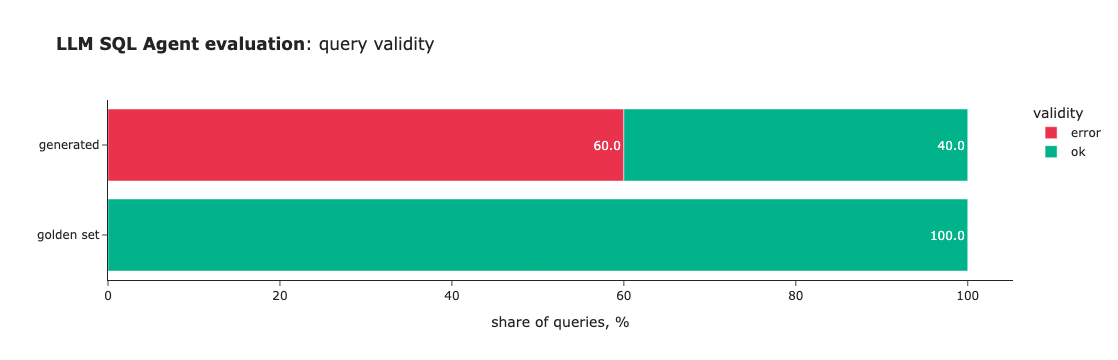

In [72]:
refl_eval_df = evaluate_sql_agent(generate_query_reflection, golden_df)

In [73]:
pd.DataFrame(refl_eval_df.generated_output.value_counts())

,count
generated_output,
"sum(if(equals(is_fraud, 0), 1, 0))\n455376\n",1
"divide(multiply(CAST(sum(if(equals(is_fraud, 1), 1, 0)), \'Float\'), 100), count())\n1.0058579080541428\n",1
share\n57.87996683461955\n,1
"Database returned the following error:\nCode: 47. DB::Exception: Missing columns: 'age' 'country' while processing query: 'SELECT sum(revenue) FROM ecommerce.sessions WHERE (toMonth(action_date) = 12) AND ((action_date >= '2024-01-01') AND (action_date < '2025-01-01')) AND (country = 'Netherlands') AND (age >= 55)', required columns: 'action_date' 'country' 'age' 'revenue', maybe you meant: 'action_date' or 'revenue'. (UNKNOWN_IDENTIFIER) (version 23.12.1.414 (official build))\n",1
"Database returned the following error:\nCode: 47. DB::Exception: Missing columns: 'country' while processing query: 'SELECT country, percentile(0.5)(revenue) AS median_revenue, percentile(0.75)(revenue) - percentile(0.25)(revenue) AS iqr FROM ecommerce.sessions GROUP BY country', required columns: 'country' 'revenue', maybe you meant: 'revenue'. (UNKNOWN_IDENTIFIER) (version 23.12.1.414 (official build))\n",1
"Database returned the following error:\nCode: 42. DB::Exception: Number of arguments for function dateDiff doesn't match: passed 2, should be 3 or 4: While processing dateDiff(first_purchase, first_session). (NUMBER_OF_ARGUMENTS_DOESNT_MATCH) (version 23.12.1.414 (official build))\n",1
"Database returned the following error:\nCode: 47. DB::Exception: Missing columns: 'YEAR' 'MONTH' while processing query: 'SELECT os, count() AS count FROM ecommerce.sessions WHERE (extract(MONTH, action_date) = 12) AND (extract(YEAR, action_date) = 2024) GROUP BY os', required columns: 'os' 'MONTH' 'action_date' 'YEAR', maybe you meant: 'os' or 'action_date'. (UNKNOWN_IDENTIFIER) (version 23.12.1.414 (official build))\n",1
browser\tcount\nChrome\t593442\nSafari\t521440\nFirefox\t320815\n,1
Database returned the following error:\nCode: 47. DB::Exception: There's no column 'T2.browser' in table 'T2': While processing T2.browser. (UNKNOWN_IDENTIFIER) (version 23.12.1.414 (official build))\n,1


In [76]:
rec = refl_eval_df[refl_eval_df.generated_output_valid != 'error'].to_dict('records')[0]

In [77]:
rec

{'question': 'How many customers made purchase in December 2024?',
 'sql_query': "select uniqExact(user_id) as customers from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) format TabSeparatedWithNames",
 'id': 0,
 'generated_query': 'SELECT SUM(CASE WHEN is_fraud = 0 THEN 1 ELSE 0 END) FROM ecommerce.sessions WHERE EXTRACT(YEAR FROM action_date) = 2024 AND EXTRACT(MONTH FROM action_date) = 12 AND user_id IN (SELECT user_id FROM ecommerce.users WHERE is_active = 1) format TabSeparatedWithNames',
 'golden_output': 'customers\n114032\n',
 'generated_output': 'sum(if(equals(is_fraud, 0), 1, 0))\n455376\n',
 'golden_output_valid': 'ok',
 'generated_output_valid': 'ok'}

# Estimating correctness

In [170]:
accuracy_system_prompt = '''
You are a senior and very diligent QA specialist and your task is to compare data in datasets. 
They are similar if they are almost identical, or if they convey the same information. 
Disregard if column names specified in the first row have different names or in a different order.
Focus on comparing the actual information (numbers). If values in datasets are different, than it means that they are not identical.
Always execute tool to provide results.
'''

In [171]:
@tool
def compare_datasets(comments: str, score: int) -> str:
    """Stores info about datasets.

    Args:
        comments (str): 1-2 sentences about the comparison of datasets,
        score (int): 0 if dataset provides different values and 1 if it shows identical information
    """
    pass

In [ ]:
# ! pip install -qU langchain-openai

In [187]:
from langchain_openai import ChatOpenAI

accuracy_chat_llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0.0).bind_tools([compare_datasets])

In [188]:
def get_openai_prompt(question, system):
    messages = [
        ("system", system),
        ("human", question)
    ]
    return messages

In [189]:
# accuracy_chat_llm = ChatOllama(model="llama3.1:8b", temperature = 0.0).bind_tools([compare_datasets])

In [190]:
accuracy_question_tmp = '''
Here are the two datasets to compare delimited by ####

Dataset #1: 
####
{dataset1}
####

Dataset #2: 
####
{dataset2}
####
'''

In [178]:
# prompt = get_llama_prompt(accuracy_question_tmp.format(dataset1 = rec['golden_output'], dataset2 = rec['generated_output']),
#                          accuracy_system_prompt)
# print(prompt)

In [179]:
# accuracy_result = accuracy_chat_llm.invoke(prompt)

In [180]:
# accuracy_result.tool_calls[0]['args']['score']

In [181]:
prompt = get_openai_prompt(accuracy_question_tmp.format(dataset1 = 'customers\n114032\n', dataset2 = 'customers\n114031\n'),
                         accuracy_system_prompt)
# print(prompt)

# accuracy_result = accuracy_chat_llm.invoke(prompt)
# accuracy_result.tool_calls[0]['args']

In [182]:
prompt = get_openai_prompt(accuracy_question_tmp.format(dataset1 = 'users\n114032\n', dataset2 = 'customers\n114032\n'),
                         accuracy_system_prompt)
# print(prompt)

# accuracy_result = accuracy_chat_llm.invoke(prompt)
# accuracy_result.tool_calls[0]['args']

In [195]:
import plotly.io as pio
pio.templates.default = 'simple_white'

def is_answer_accurate(output1, output2):
    prompt = get_openai_prompt(accuracy_question_tmp.format(dataset1 = output1, dataset2 = output2),
        accuracy_system_prompt)
    accuracy_result = accuracy_chat_llm.invoke(prompt)
    try:
        return accuracy_result.tool_calls[0]['args']['score']
    except:
        return None

def evaluate_sql_agent(generate_query_func, golden_df):
  # generating SQL
  tmp = []
  for rec in tqdm.tqdm(golden_df.to_dict('records')):
    generated_query = generate_query_func(rec['question'])
    tmp.append(
      {
          'id': rec['id'],
          'generated_query': generated_query
      }
    )

  eval_df = golden_df.merge(pd.DataFrame(tmp))

  # executing SQL queries

  tmp = []

  for rec in tqdm.tqdm(eval_df.to_dict('records')):
    golden_output = get_clickhouse_data(rec['sql_query'])
    generated_output = get_clickhouse_data(rec['generated_query'])

    tmp.append(
        {
            'id': rec['id'],
            'golden_output': golden_output,
            'generated_output': generated_output
        }
    )

  eval_df = eval_df.merge(pd.DataFrame(tmp))

  # checking validity
  eval_df['golden_output_valid'] = eval_df.golden_output.map(is_valid_output)
  eval_df['generated_output_valid'] = eval_df.generated_output.map(is_valid_output)
  
  eval_df['correct_output'] = list(map(
      is_answer_accurate,
      eval_df['golden_output'],
      eval_df['generated_output']
  ))

  eval_df['accuracy'] = list(map(
      lambda x, y: 'invalid: ' + x if x != 'ok' else ('correct' if y == 1 else 'incorrect'),
      eval_df.generated_output_valid,
      eval_df.correct_output
  ))

  valid_stats_df = (eval_df.groupby('golden_output_valid')[['id']].count().rename(columns = {'id': 'golden set'}).join(
    eval_df.groupby('generated_output_valid')[['id']].count().rename(columns = {'id': 'generated'}), how = 'outer')).fillna(0).T

  fig = px.bar(valid_stats_df.apply(lambda x: 100*x/valid_stats_df.sum(axis = 1)),
      orientation = 'h', title = '<b>LLM SQL Agent evaluation</b>: query validity',
       text_auto = '.1f',
       color_discrete_map = {'ok': '#00b38a', 'error': '#ea324c', 'too many rows': '#f2ac42'},
      labels = {'index': '', 'variable': 'validity', 'value': 'share of queries, %'})

  fig.show()

  accuracy_stats_df = eval_df.groupby('accuracy')[['id']].count()
  accuracy_stats_df['share'] = accuracy_stats_df.id*100/accuracy_stats_df.id.sum()

  fig = px.bar(accuracy_stats_df[['share']],
      title = '<b>LLM SQL Agent evaluation</b>: query accuracy',
       text_auto = '.1f', orientation = 'h',
       color_discrete_sequence = ['#0077B5'],
      labels = {'index': '', 'variable': 'accuracy', 'value': 'share of queries, %'})

  fig.update_layout(showlegend = False)
  fig.show()

  return eval_df

  0%|                                                                                                                                                                                    | 0/10 [00:00<?, ?it/s]

Initial query: SELECT COUNT(DISTINCT user_id) FROM ecommerce.sessions WHERE YEAR(action_date) = 2024 AND MONTH(action_date) = 12


 10%|█████████████████▏                                                                                                                                                          | 1/10 [00:11<01:46, 11.89s/it]

Reflected query: SELECT COUNT(DISTINCT user_id) FROM ecommerce.sessions WHERE YEAR(action_date) = 2024 AND MONTH(action_date) = 12 format TabSeparatedWithNames
Initial query: SELECT CAST(SUM(CASE WHEN is_fraud = 1 THEN 1 ELSE 0 END) AS Float) * 100 / COUNT(session_id) FROM ecommerce.sessions WHERE YEAR(action_date) = 2023


 20%|██████████████████████████████████▍                                                                                                                                         | 2/10 [00:24<01:38, 12.37s/it]

Reflected query: SELECT CAST(SUM(CASE WHEN is_fraud = 1 THEN 1 ELSE 0 END) AS Float) * 100 / COUNT(session_id) FROM ecommerce.sessions WHERE YEAR(action_date) = 2023 format TabSeparatedWithNames
Initial query: SELECT count(DISTINCT T1.user_id) / (SELECT COUNT(user_id) FROM ecommerce.sessions WHERE action_date = (CURRENT_DATE - INTERVAL '1 day')) * 100 FROM ecommerce.sessions AS T1 JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T1.os = 'Windows'


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 3/10 [00:41<01:40, 14.34s/it]

Reflected query: SELECT count(DISTINCT T1.user_id) / (SELECT COUNT(user_id) FROM ecommerce.sessions WHERE action_date = (CURRENT_DATE - INTERVAL '1 day')) * 100 FROM ecommerce.sessions AS T1 JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T1.os = 'Windows' format TabSeparatedWithNames
Initial query: SELECT SUM(T2.revenue) FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T2.country = 'Netherlands' AND T1.action_date LIKE '%-12-2024' AND T2.age >= 55


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 4/10 [01:04<01:46, 17.81s/it]

Reflected query: SELECT SUM(T2.revenue) FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T2.country = 'Netherlands' AND T1.action_date LIKE '%-12-2024' AND T2.age >= 55 format TabSeparatedWithNames
Initial query: SELECT country, quantile(0.5, AGG_REVENUE) AS median_revenue, quantile(0.75, AGG_REVENUE) - quantile(0.25, AGG_REVENUE) AS IQR FROM ( SELECT country, revenue FROM ecommerce.sessions WHERE is_fraud = 0 GROUP BY country ) GROUP BY country


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 5/10 [01:33<01:49, 21.85s/it]

Reflected query: SELECT country, quantile(0.5, AGG_REVENUE) AS median_revenue, quantile(0.75, AGG_REVENUE) - quantile(0.25, AGG_REVENUE) AS IQR FROM ( SELECT country, revenue FROM ecommerce.sessions WHERE is_fraud = 0 GROUP BY country ) GROUP BY country format TabSeparatedWithNames
Initial query: SELECT AVG(DATEDIFF('day', MIN(action_date), action_date)) as avg_days FROM ecommerce.sessions WHERE revenue > 0 GROUP BY user_id


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 6/10 [01:53<01:25, 21.38s/it]

Reflected query: SELECT AVG(DATEDIFF('day', MIN(action_date), action_date)) as avg_days FROM ecommerce.sessions WHERE revenue > 0 GROUP BY user_id format TabSeparatedWithNames
Initial query: SELECT os, COUNT(session_id) as count FROM ecommerce.sessions WHERE STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-01' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-02' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-03' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-04' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-05' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-06' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-07' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-08' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-09' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-10' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-11' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-12' OR STR_TO_DATE(action_date, 'yyyy-MM-dd') = '2024-12-13' OR 

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 7/10 [03:40<02:27, 49.21s/it]

Reflected query: SELECT os, COUNT(session_id) as count FROM ecommerce.sessions WHERE action_date >= '2024-12-01' AND action_date <= '2024-12-31' GROUP BY os format TabSeparatedWithNames
Initial query: SELECT browser1, browser2, COUNT(DISTINCT user_id) as count FROM (SELECT user_id, browser AS browser1, LAG(browser) OVER (PARTITION BY user_id ORDER BY session_id) AS browser2 FROM ecommerce.sessions WHERE YEAR(action_date) = 2024 GROUP BY user_id, browser) t WHERE browser2 IS NOT NULL GROUP BY browser1, browser2


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 8/10 [04:06<01:23, 41.86s/it]

Reflected query: SELECT browser1, browser2, COUNT(DISTINCT user_id) as count FROM (SELECT user_id, browser AS browser1, LAG(browser) OVER (PARTITION BY user_id ORDER BY session_id) AS browser2 FROM ecommerce.sessions WHERE YEAR(action_date) = 2024 GROUP BY user_id, browser) t WHERE browser2 IS NOT NULL GROUP BY browser1, browser2 format TabSeparatedWithNames
Initial query: SELECT browser, SUM(is_fraud) AS total_fraud_count, COUNT(*) AS total_sessions FROM ecommerce.sessions GROUP BY browser ORDER BY total_fraud_count / COUNT(*) DESC LIMIT 1


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9/10 [04:22<00:33, 33.73s/it]

Reflected query: SELECT browser, SUM(is_fraud) AS total_fraud_count, COUNT(*) AS total_sessions FROM ecommerce.sessions GROUP BY browser ORDER BY total_fraud_count / COUNT(*) DESC LIMIT 1 format TabSeparatedWithNames
Initial query: SELECT T2.country FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE EXTRACT(YEAR FROM T1.action_date) = 2024 AND T1.is_fraud = 0 AND T2.is_active = 1 GROUP BY T2.country ORDER BY COUNT(T1.session_id) DESC LIMIT 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:50<00:00, 29.04s/it]


Reflected query: SELECT T2.country FROM ecommerce.sessions AS T1 INNER JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE EXTRACT(YEAR FROM T1.action_date) = 2024 AND T1.is_fraud = 0 AND T2.is_active = 1 GROUP BY T2.country ORDER BY COUNT(T1.session_id) DESC LIMIT 1 format TabSeparatedWithNames


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


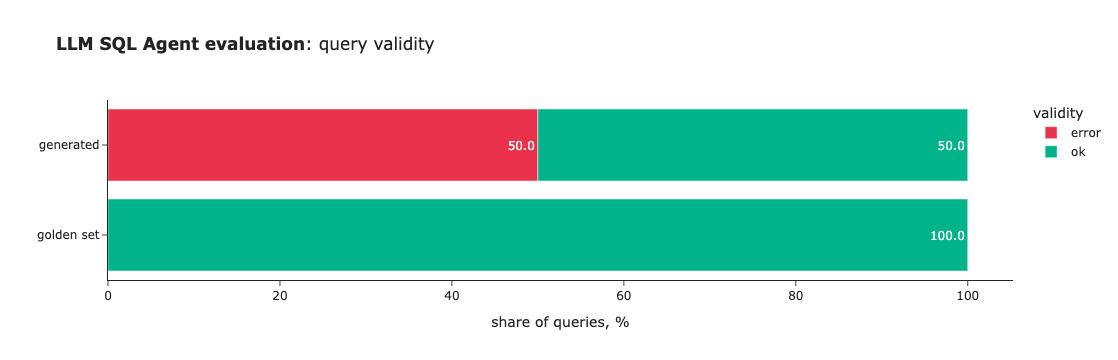

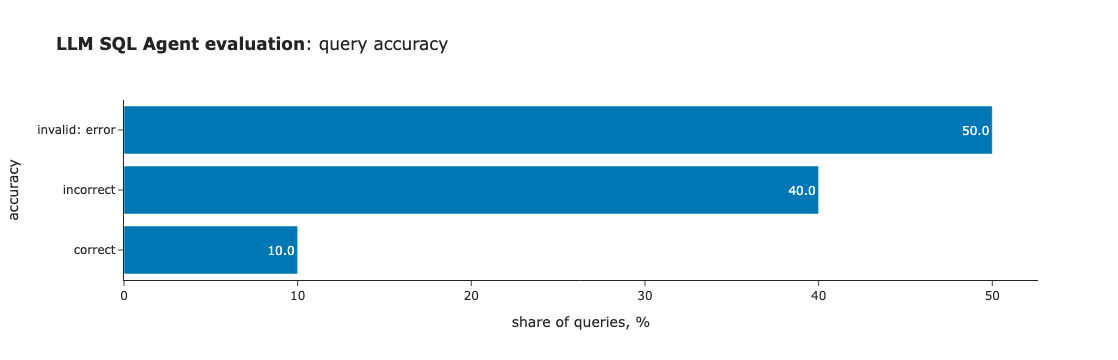

In [199]:
refl_eval_df = evaluate_sql_agent(generate_query_reflection, golden_df)

In [202]:
refl_eval_df.to_csv('results_self_reflection.csv', index = False, sep = '\t')

In [203]:
refl_eval_df.generated_output.value_counts()

generated_output
uniqExact(user_id)\n280703\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1
divide(multiply(CAST(sum(if(equals(is_fraud, 1), 1, 0)), \'Float\'), 100), count(session_id))\n1.0058579080541428\n                  

In [207]:
refl_eval_df[refl_eval_df.accuracy == 'correct'].T

,6
question,"What is the number of sessions in December 2024, broken down by operating systems, including the totals?"
sql_query,"SELECT os, uniqExact(session_id) as total FROM ecommerce.sessions WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY os with totals format TabSeparatedWithNames"
id,6
generated_query,"SELECT os, COUNT(session_id) as count FROM ecommerce.sessions WHERE action_date >= '2024-12-01' AND action_date <= '2024-12-31' GROUP BY os format TabSeparatedWithNames"
golden_output,os\ttotal\nAndroid\t192377\niOS\t9751\nWindows\t281912\n\n\t484040\n
generated_output,os\tcount\nAndroid\t192377\niOS\t9751\nWindows\t281912\n
golden_output_valid,ok
generated_output_valid,ok
correct_output,1
accuracy,correct


### RAG

In [208]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [211]:
# ! pip install langchain_chroma

In [366]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

In [367]:
# print(vector_store._collection.count())

In [368]:
# vector_store.delete_collection()

In [369]:
q = '''
select uniqExact(s.user_id) as customers 
from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id 
where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) and (u.age >= 30) and (u.age <= 40) format TabSeparatedWithNames
'''

print(get_clickhouse_data(q))

customers
17433



In [461]:
rag_set = [
    {
        "question": "How many customers made a purchase in November 2024?",
        "sql_query": "select uniqExact(user_id) as customers from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-11-01') and (revenue > 0) format TabSeparatedWithNames"
    },
    {
        "question": "How many active customers made a purchase in December 2024?",
        "sql_query": "select uniqExact(s.user_id) as customers from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) and (u.is_active = 1) format TabSeparatedWithNames"
    },
    {
        "question": "How many customers in the United Kingdom made a purchase in December 2024?",
        "sql_query": "select uniqExact(s.user_id) as customers from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) and (u.country = 'United Kingdom') format TabSeparatedWithNames"
    },
    {
        "question": "How many customers aged 30-40 made a purchase in December 2024?",
        "sql_query": "select uniqExact(s.user_id) as customers from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) and (u.age >= 30) and (u.age <= 40) format TabSeparatedWithNames"
    },
    {
        "question": "How many unique customers had at least one session in December 2024?",
        "sql_query": "select uniqExact(user_id) as customers from ecommerce.sessions where toStartOfMonth(action_date) = '2024-12-01' format TabSeparatedWithNames"
    },
    {
        "question": "How many sessions were marked as fraud in December 2024?",
        "sql_query": "select count(1) as fraud_sessions from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-12-01') and (is_fraud = 1) format TabSeparatedWithNames"
    },
    {
        "question": "How many customers used the Chrome browser in December 2024?",
        "sql_query": "select uniqExact(user_id) as customers from ecommerce.sessions where (toStartOfMonth(action_date) = '2024-12-01') and (browser = 'Chrome') format TabSeparatedWithNames"
    },
    {
        "question": "What percentage of sessions were fraudulent in 2023, grouped by operating system?",
        "sql_query": "select os, 100*countIf(session_id, is_fraud = 1)/count(session_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') group by os format TabSeparatedWithNames"
    },
    {
        "question": "What was the monthly fraud rate in 2023, expressed as a percentage?",
        "sql_query": "select toStartOfMonth(action_date) as month, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') group by month order by month format TabSeparatedWithNames"
    },
    {
        "question": "What was the fraud rate in 2023, grouped by browser, expressed as a percentage?",
        "sql_query": "select browser, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') group by browser format TabSeparatedWithNames"
    },
    {
        "question": "What was the fraud rate in 2023 for active users, expressed as a percentage?",
        "sql_query": "select 100*uniqExactIf(s.user_id, is_fraud = 1)/uniqExact(s.user_id) as fraud_rate from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where (toStartOfYear(action_date) = '2023-01-01') and (u.is_active = 1) format TabSeparatedWithNames"
    },
    {
        "question": "What was the share of users using Android yesterday?",
        "sql_query": "select 100*uniqExactIf(user_id, os = 'Android')/uniqExact(user_id) as android_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames"
    },
    {
        "question": "What was the share of users using Windows the day before yesterday?",
        "sql_query": "select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date = today() - 2) format TabSeparatedWithNames"
    },
    {
        "question": "What was the share of users using Safari yesterday?",
        "sql_query": "select 100*uniqExactIf(user_id, browser = 'Safari')/uniqExact(user_id) as safari_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames"
    },
    {
        "question": "What was the share of users using Windows in the last week?",
        "sql_query": "select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date >= today() - 7) and (action_date < today()) format TabSeparatedWithNames"
    },
    {
        "question": "What was the revenue from German users aged 60 and older in December 2024?",
        "sql_query": "select sum(s.revenue) from ecommerce.sessions AS s inner join ecommerce.users AS u on s.user_id = u.user_id where (u.country = 'Germany') AND (u.age >= 60) and (toStartOfMonth(action_date) = '2024-12-01') format TabSeparatedWithNames"
    },
    {
        "question": "What was the revenue from users in the United Kingdom aged 55 and older who used Android in December 2024?",
        "sql_query": "select sum(s.revenue) from ecommerce.sessions AS s inner join ecommerce.users AS u on s.user_id = u.user_id where (u.country = 'United Kingdom') AND (u.age >= 55) and (s.os = 'Android') and (toStartOfMonth(action_date) = '2024-12-01') format TabSeparatedWithNames"
    },
    {
        "question": "What are the median and interquartile range (IQR) of purchase revenue for each country, excluding users under 25 years old?",
        "sql_query": "select country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) and (u.age >= 25) group by country format TabSeparatedWithNames"
    },
    {
        "question": "What are the median and interquartile range (IQR) of purchase revenue for each country, considering only active users?",
        "sql_query": "select country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) and (u.is_active = 1) group by country format TabSeparatedWithNames"
    },
    {
        "question": "What are the median and interquartile range (IQR) of purchase revenue for each country in 2024?",
        "sql_query": "select country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) and (toStartOfYear(action_date) = '2024-01-01') group by country format TabSeparatedWithNames"
    },
    {
        "question": "What are the median and interquartile range (IQR) of purchase revenue for each country, grouped by operating system?",
        "sql_query": "select country, os, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue from ecommerce.sessions AS s inner join ecommerce.users AS u on u.user_id = s.user_id where (revenue > 0) group by country, os format TabSeparatedWithNames"
    },
    {
        "question": "What is the average number of days between the first session and the first purchase for users who made at least one purchase in 2024?",
        "sql_query": "select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select user_id, min(action_date) as first_action_date, minIf(action_date, revenue > 0) as first_purchase, max(revenue) as max_revenue from ecommerce.sessions where toStartOfYear(action_date) = '2024-01-01' group by user_id) where max_revenue > 0 format TabSeparatedWithNames"
    },
    {
        "question": "What is the average number of days between the first session and the first purchase for users in the United Kingdom?",
        "sql_query": "select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select s.user_id, min(s.action_date) as first_action_date, minIf(s.action_date, s.revenue > 0) as first_purchase, max(s.revenue) as max_revenue from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where u.country = 'United Kingdom' group by s.user_id) where max_revenue > 0 format TabSeparatedWithNames"
    },
    {
        "question": "What is the average number of days between the first session and the first purchase for users aged 30-40 who made at least one purchase?",
        "sql_query": "select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select s.user_id, min(s.action_date) as first_action_date, minIf(s.action_date, s.revenue > 0) as first_purchase, max(s.revenue) as max_revenue from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where (u.age >= 30) and (u.age <= 40) group by s.user_id) where max_revenue > 0 format TabSeparatedWithNames"
    },
    {
        "question": "What is the number of sessions in December 2024, broken down by browsers, including the totals?",
        "sql_query": "SELECT browser, uniqExact(session_id) as total FROM ecommerce.sessions WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY browser with totals format TabSeparatedWithNames"
    },
    {
        "question": "What is the number of sessions in December 2024, broken down by operating systems and user age groups, including the totals?",
        "sql_query": "SELECT os, CASE WHEN u.age < 30 THEN 'Under 30' WHEN u.age BETWEEN 30 AND 50 THEN '30-50' ELSE 'Over 50' END as age_group, uniqExact(session_id) as total FROM ecommerce.sessions s JOIN ecommerce.users u ON s.user_id = u.user_id WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY os, age_group with totals format TabSeparatedWithNames"
    },
    {
        "question": "What is the number of sessions in December 2024, broken down by operating systems for users from the Netherlands, including the totals?",
        "sql_query": "SELECT os, uniqExact(session_id) as total FROM ecommerce.sessions s JOIN ecommerce.users u ON s.user_id = u.user_id WHERE toStartOfMonth(action_date) = '2024-12-01' AND u.country = 'Netherlands' GROUP BY os with totals format TabSeparatedWithNames"
    },
    {
        "question": "Which browser has the highest share of fraud users in 2024?",
        "sql_query": "select browser, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where toStartOfYear(action_date) = '2024-01-01' group by browser order by fraud_rate desc limit 1 format TabSeparatedWithNames"
    },
    {
        "question": "Which operating system has the highest share of fraud users?",
        "sql_query": "select os, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions group by os order by fraud_rate desc limit 1 format TabSeparatedWithNames"
    },
    {
        "question": "Which browser has the highest share of fraud users in the United Kingdom?",
        "sql_query": "select browser, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where u.country = 'United Kingdom' group by browser order by fraud_rate desc limit 1 format TabSeparatedWithNames"
    },

    {
        "question": "Which country had the highest number of first-time users in Q1 2024?",
        "sql_query": "select country, count(distinct user_id) as users from (select user_id, min(action_date) as first_date from ecommerce.sessions group by user_id having toStartOfQuarter(first_date) = '2024-01-01') as t inner join ecommerce.users as u on t.user_id = u.user_id group by country order by users desc limit 1 format TabSeparatedWithNames"
    },
    {
        "question": "Which country had the highest number of first-time users in 2024, excluding users under 18 years old?",
        "sql_query": "select country, count(distinct user_id) as users from (select user_id, min(action_date) as first_date from ecommerce.sessions group by user_id having toStartOfYear(first_date) = '2024-01-01') as t inner join ecommerce.users as u on t.user_id = u.user_id where u.age >= 18 group by country order by users desc limit 1 format TabSeparatedWithNames"
    }
]

In [462]:
import json

In [463]:
# print(json.dumps(golden_set, indent=2))

In [465]:
with open('rag_set.json', 'r') as f:
    rag_set = json.loads(f.read())

In [466]:
len(rag_set_df)

32

In [467]:
rag_set_df = pd.DataFrame(rag_set)

In [468]:
rag_set_df['output'] = rag_set_df['sql_query'].map(get_clickhouse_data)
# rag_set_df.head()

In [469]:
rag_set_df['is_valid'] = rag_set_df['output'].map(is_valid_output)
rag_set_df.is_valid.value_counts()

is_valid
ok    32
Name: count, dtype: int64

In [470]:
rag_set_df[rag_set_df.is_valid != 'ok']

,question,sql_query,output,is_valid


In [376]:
rag_set_df['formatted_txt'] = list(map(
    lambda x, y: 'Question: %s; Answer: %s' % (x, y),
    rag_set_df.question,
    rag_set_df.sql_query
))

In [377]:
# https://python.langchain.com/docs/how_to/document_loader_csv/

In [378]:
import tempfile
from io import StringIO

string_data = '\n\n'.join(rag_set_df.formatted_txt)


# with tempfile.NamedTemporaryFile(delete=False, mode="w+") as temp_file:
#     temp_file.write(string_data)
#     temp_file_path = temp_file.name

In [379]:
# print(string_data)

In [380]:
# from langchain_community.document_loaders.text import TextLoader
# loader = TextLoader(file_path=temp_file_path)
# data = loader.load()

In [381]:
# ! pip install -qU langchain-text-splitters

In [382]:
from langchain_text_splitters import CharacterTextSplitter

In [383]:
text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=0,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

In [384]:
texts = text_splitter.create_documents([string_data])

Created a chunk of size 232, which is longer than the specified 0
Created a chunk of size 313, which is longer than the specified 0
Created a chunk of size 341, which is longer than the specified 0
Created a chunk of size 331, which is longer than the specified 0
Created a chunk of size 228, which is longer than the specified 0
Created a chunk of size 232, which is longer than the specified 0
Created a chunk of size 247, which is longer than the specified 0
Created a chunk of size 296, which is longer than the specified 0
Created a chunk of size 336, which is longer than the specified 0
Created a chunk of size 306, which is longer than the specified 0
Created a chunk of size 353, which is longer than the specified 0
Created a chunk of size 242, which is longer than the specified 0
Created a chunk of size 257, which is longer than the specified 0
Created a chunk of size 244, which is longer than the specified 0
Created a chunk of size 278, which is longer than the specified 0
Created a 

In [385]:
len(texts)

32

In [386]:
# texts

In [387]:
# vector_store.reset_collection()

In [388]:
document_ids = vector_store.add_documents(documents=texts)

In [389]:
vector_store._collection.count()

32

In [408]:
question = 'What was the share of users using Windows yesterday?'

In [409]:
retrieved_docs = vector_store.similarity_search(question, 3)
# retrieved_docs = vector_store.max_marginal_relevance_search('What was the share of users using Windows yesterday?', 3)

In [410]:
len(retrieved_docs)

3

In [411]:
context = "\n\n".join(map(lambda x: x.page_content, retrieved_docs))
print(context)

Question: What was the share of users using Windows the day before yesterday?; Answer: select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date = today() - 2) format TabSeparatedWithNames

Question: What was the share of users using Windows in the last week?; Answer: select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date >= today() - 7) and (action_date < today()) format TabSeparatedWithNames

Question: What was the share of users using Android yesterday?; Answer: select 100*uniqExactIf(user_id, os = 'Android')/uniqExact(user_id) as android_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames


In [413]:
generate_query_system_prompt_with_examples_tmpl = '''
You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- session_id (integer) - unique identifier of session, for example, 106 or 1023
- action_date (date) - session start date, for example, "2021-01-03" or "2024-12-02"
- session_duration (integer) - duration of session in seconds, for example, 125 or 49
- os (string) - operation system that customer used, for example, "Windows" or "Android"
- browser (string) - browser that customer used, for example, "Chrome" or "Safari"
- is_fraud (integer) - 1 if session is marked as fraud and 0 otherwise
- revenue (float) - income in USD (the sum of purchased items), for example, 0.0 or 1506.7


Write a query in ClickHouse SQL to answer the following question. 
Add "format TabSeparatedWithNames" at the end of the query to get data from ClickHouse database in the right format. 
Answer questions following the instructions and providing all the needed information and sharing your reasoning. 

Examples of questions and answers: 
{examples}
'''

In [414]:
generate_query_reflection(question)

Initial query: SELECT COUNT(DISTINCT T1.user_id) / (SELECT COUNT(DISTINCT user_id) FROM ecommerce.sessions WHERE action_date = CURRENT_DATE - INTERVAL 1 DAY) * 100 AS share_of_windows_users FROM ecommerce.sessions AS T1 JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T1.os = 'Windows' format TabSeparatedWithNames
Reflected query: SELECT COUNT(DISTINCT T1.user_id) / (SELECT COUNT(DISTINCT user_id) FROM ecommerce.sessions WHERE action_date = TODAY - INTERVAL 1 DAY) * 100 AS share_of_windows_users FROM ecommerce.sessions AS T1 JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T1.os = 'Windows' format TabSeparatedWithNames


"SELECT COUNT(DISTINCT T1.user_id) / (SELECT COUNT(DISTINCT user_id) FROM ecommerce.sessions WHERE action_date = TODAY - INTERVAL 1 DAY) * 100 AS share_of_windows_users FROM ecommerce.sessions AS T1 JOIN ecommerce.users AS T2 ON T1.user_id = T2.user_id WHERE T1.os = 'Windows' format TabSeparatedWithNames"

In [ ]:
# def generate_query_rag(question):
#     prompt = get_llama_prompt(question, generate_query_system_prompt)
#     result = chat_llm.invoke(prompt)
#     try:
#         generated_query = result.tool_calls[0]['args']['query']
#     except:
#         generated_query = ''
#     return generated_query

In [415]:
prompt = get_llama_prompt(question, generate_query_system_prompt_with_examples_tmpl.format(examples = context))
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

Table: ecommerce.sessions 
Description: sessions of usage the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- session_id (integer) - unique identifier of session, for example, 106 or 1023
- action_date (date) - session start date, for example, "2021-01-03" or "2024-12-02"
- session_duration (integer) - 

In [416]:
result = chat_llm.invoke(prompt)

In [420]:
generated_query = result.tool_calls[0]['args']['query']

In [421]:
print(get_clickhouse_data(generated_query))

windows_share
60.957989791912055



In [427]:
print(get_clickhouse_data(golden_df[golden_df.question == question].sql_query.values[0]))

windows_share
60.957989791912055



In [428]:
def generate_query_rag(question):
    retrieved_docs = vector_store.similarity_search(question, 3)
    context = context = "\n\n".join(map(lambda x: x.page_content, retrieved_docs))
    prompt = get_llama_prompt(question, generate_query_system_prompt_with_examples_tmpl.format(examples = context))
    result = chat_llm.invoke(prompt)
    try:
        generated_query = result.tool_calls[0]['args']['query']
    except:
        generated_query = ''
    return generated_query

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.83it/s]


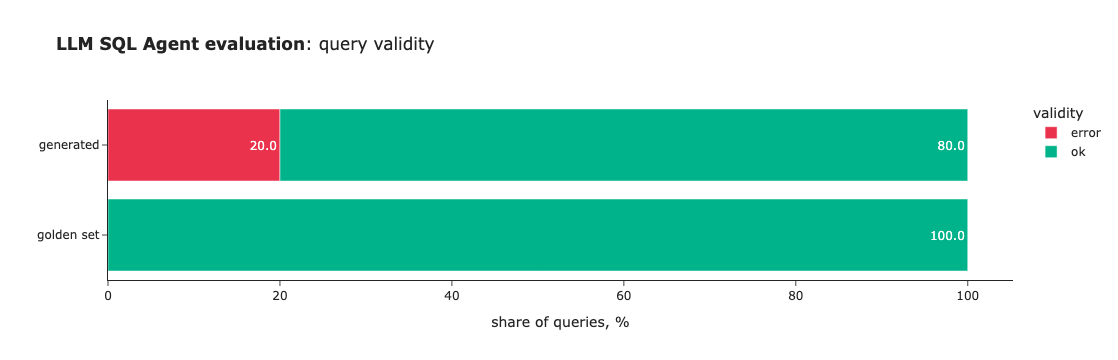

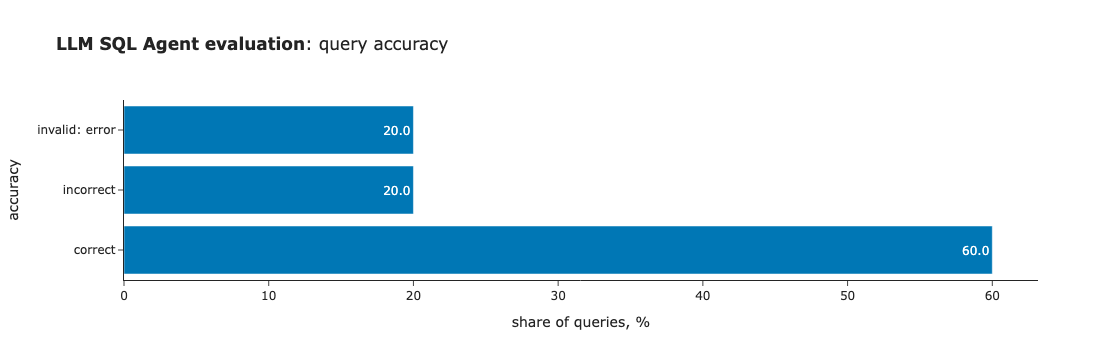

In [429]:
rag_eval_df = evaluate_sql_agent(generate_query_rag, golden_df)

In [436]:
def generate_query_rag_with_reflection(question):
    generated_query = generate_query_rag(question) 
    print('Initial query:', generated_query)
    db_output = get_clickhouse_data(generated_query)
    is_valid_db_output = is_valid_output(db_output)
    if is_valid_db_output == 'too many rows':
        db_output = "Database unexpectedly returned more than 1000 rows."

    if is_valid_db_output == 'ok': 
        return generated_query
    else:
        reflection_user_query = reflection_user_query_tmpl.format(
            question = question,
            query = generated_query,
            output = db_output
        )
        
        reflection_prompt = get_llama_prompt(reflection_user_query, generate_query_system_prompt) 
        print('Reflection prompt:', reflection_prompt)
        reflection_result = chat_llm.invoke(reflection_prompt)

        try:
            reflected_query = reflection_result.tool_calls[0]['args']['query']
        except:
            reflected_query = ''
        print('Reflected query:', reflected_query)
        return reflected_query

 10%|█████████████████▏                                                                                                                                                          | 1/10 [00:09<01:27,  9.72s/it]

Initial query: select uniqExact(s.user_id) as customers from ecommerce.sessions s where (toStartOfMonth(action_date) = '2024-12-01') and (revenue > 0) format TabSeparatedWithNames
Initial query: select 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01')
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 7

 20%|██████████████████████████████████▍                                                                                                                                         | 2/10 [00:26<01:50, 13.76s/it]

Reflected query: select 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions where (toStartOfYear(action_date) = '2023-01-01') format TabSeparatedWithNames


 30%|███████████████████████████████████████████████████▌                                                                                                                        | 3/10 [00:41<01:41, 14.53s/it]

Initial query: select 100*uniqExactIf(user_id, os = 'Windows')/uniqExact(user_id) as windows_share from ecommerce.sessions where (action_date = today() - 1) format TabSeparatedWithNames


 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 4/10 [01:04<01:45, 17.63s/it]

Initial query: SELECT sum(s.revenue) FROM ecommerce.sessions AS s JOIN ecommerce.users AS u ON s.user_id = u.user_id WHERE (u.country = 'Netherlands') AND (u.age >= 55) AND (toStartOfMonth(action_date) = '2024-12-01') format TabSeparatedWithNames
Initial query: SELECT country, median(revenue) as median_revenue, quantile(0.25)(revenue) as percentile_25_revenue, quantile(0.75)(revenue) as percentile_75_revenue FROM ecommerce.sessions AS s INNER JOIN ecommerce.users AS u ON u.user_id = s.user_id WHERE (u.is_active = 1) GROUP BY country format TabSeparatedWithNames


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 5/10 [01:26<01:37, 19.45s/it]

Initial query: select avg(first_purchase - first_action_date) as avg_days_to_purchase from (select s.user_id, min(s.action_date) as first_action_date, minIf(s.action_date, s.revenue > 0) as first_purchase, max(s.revenue) as max_revenue from ecommerce.sessions s join ecommerce.users u on s.user_id = u.user_id where s.revenue > 0 group by s.user_id) where max_revenue > 0 format TabSeparatedWithNames


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 7/10 [02:02<00:54, 18.18s/it]

Initial query: SELECT os, uniqExact(session_id) as total FROM ecommerce.sessions WHERE toStartOfMonth(action_date) = '2024-12-01' GROUP BY os with totals format TabSeparatedWithNames
Initial query: SELECT os, browser, uniqExact(user_id) as num_customers FROM ecommerce.sessions WHERE toStartOfYear(action_date) = '2024-01-01' GROUP BY os, browser
Reflection prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>


You are a senior data analyst with more than 10 years of experience writing complex SQL queries. 
There are two tables in the database you're working with with the following schemas. 

Table: ecommerce.users 
Description: customers of the online shop
Fields: 
- user_id (integer) - unique identifier of customer, for example, 1000004 or 3000004
- country (string) - country of residence, for example, "Netherlands" or "United Kingdom"
- is_active (integer) - 1 if customer is still active and 0 otherwise
- age (integer) - customer age in full years, for example, 31 or 72

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 8/10 [02:25<00:39, 19.61s/it]

Reflected query: SELECT os, browser, uniqExact(user_id) as num_customers FROM ecommerce.sessions WHERE toStartOfYear(action_date) = '2024-01-01' GROUP BY os, browser format TabSeparatedWithNames
Initial query: select browser, 100*uniqExactIf(user_id, is_fraud = 1)/uniqExact(user_id) as fraud_rate from ecommerce.sessions group by browser order by fraud_rate desc limit 1 format TabSeparatedWithNames


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 9/10 [02:42<00:18, 18.77s/it]

Initial query: select u.country, count(distinct t.user_id) as users from (select user_id, min(action_date) as first_date from ecommerce.sessions group by user_id having toYear(first_date) = '2024') as t inner join ecommerce.users as u on t.user_id = u.user_id group by u.country order by users desc limit 1 format TabSeparatedWithNames


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.88it/s]


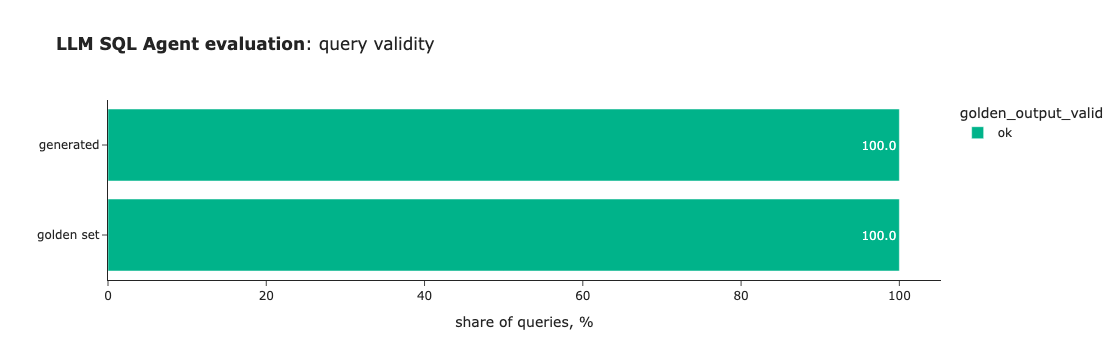

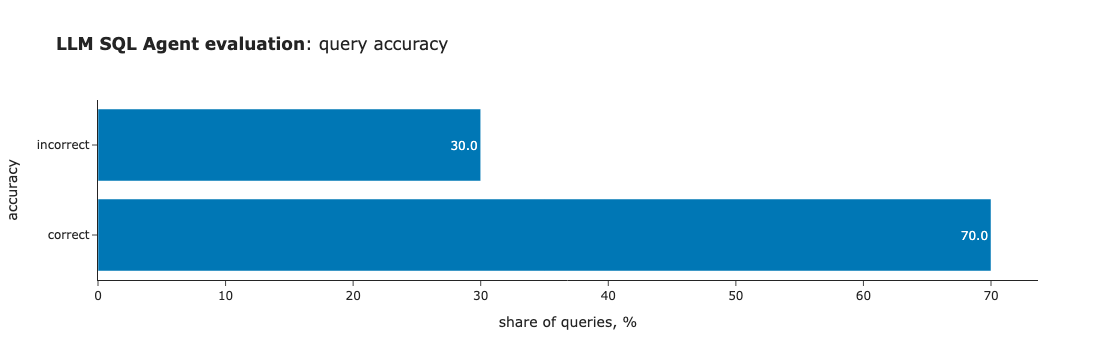

In [441]:
rag_refl_eval_df = evaluate_sql_agent(generate_query_rag_with_reflection, golden_df)